In [1]:
from fastbook import *

In [2]:
from fastai.vision.widgets import *

In [3]:
key = open('azurekey.txt').readline().strip('\n')
print(key)

32a395749721415f8aedf5a0ef7ca0d2


In [4]:
catPositions = ['loaf', 'curled up', 'belly up', 'stretching', 'contortionist']
catPath = Path('catPics')

In [5]:
if not catPath.exists():
    catPath.mkdir()
    for i in catPositions:
        dest = (path/i)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'cat \"{i}\"') #search terms for the different cat positions (eg cat "loaf")
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
catFiles = get_image_files(catPath)
catFiles

(#622) [Path('catPics/belly up/00000002.jpg'),Path('catPics/belly up/00000028.jpg'),Path('catPics/belly up/00000117.jpg'),Path('catPics/belly up/00000108.jpg'),Path('catPics/belly up/00000057.jpg'),Path('catPics/belly up/00000053.jpg'),Path('catPics/belly up/00000130.jpg'),Path('catPics/belly up/00000030.jpg'),Path('catPics/belly up/00000094.jpg'),Path('catPics/belly up/00000091.JPG')...]

In [7]:
failed = verify_images(catFiles)
failed

(#0) []

In [8]:
failed.map(Path.unlink)

(#0) []

In [9]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #TODO: make a splitter that splits it 3 ways, valid, test, and train without using GrandParent
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms())

In [10]:
catDls = cats.dataloaders(catPath)

/home/itprentice/miniconda3/envs/fastbook_learning/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


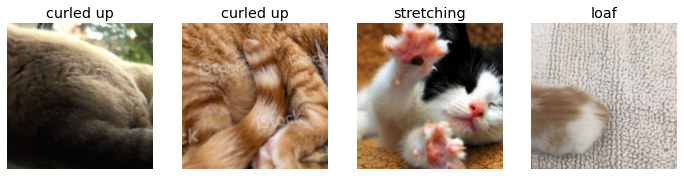

In [11]:
catDls.train.show_batch(max_n=4, nrows=1, unique=False)

In [12]:
catLearn = cnn_learner(catDls, resnet34, metrics=error_rate) #create the learner to train the model with
catLearn.recorder #initialize the recorder associated with the learner to plot loss later


/home/itprentice/miniconda3/envs/fastbook_learning/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Recorder

In [13]:
catLearn.fine_tune(9) #fine tuning for head setup + 8 epochs
#choose 8 epochs because it is the point where train loss and valid loss are the most similar

epoch,train_loss,valid_loss,error_rate,time
0,2.575145,1.494696,0.491935,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.561307,1.163333,0.435484,00:11
1,1.415596,1.000151,0.338710,00:11
2,1.294394,0.966100,0.354839,00:11
3,1.140395,0.847266,0.306452,00:12
4,1.022010,0.808837,0.282258,00:11
5,0.917170,0.765695,0.266129,00:12
6,0.830274,0.752356,0.266129,00:11
7,0.753798,0.731420,0.250000,00:11
8,0.693351,0.730747,0.266129,00:11


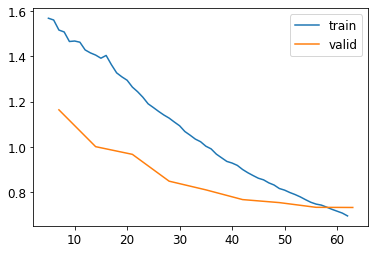

In [14]:
catLearn.recorder.plot_loss() #i believe this plots loss vs # batches processed

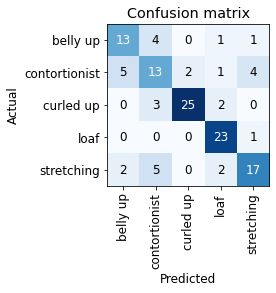

In [15]:
interp = ClassificationInterpretation.from_learner(catLearn)
interp.plot_confusion_matrix()

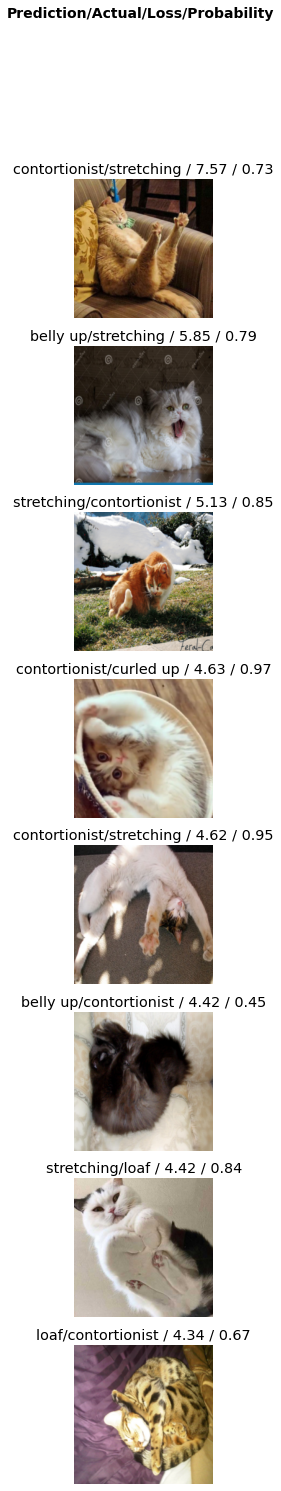

In [16]:
interp.plot_top_losses(8, nrows=8)

In [17]:
catLearn.export(fname='catexport.pkl')
#catLearn.save('catsave.pkl') the save file is too big to upload to github

Path('models/catsave.pkl.pth')

In [18]:
learn_inf = load_learner('catexport.pkl')